# Assessing Product Marketing Impact

### Problem Statement

#### Our task is to assess the efficacy of marketing efforts promoting the company's new "PWV" product. Specifically, we want to know if marketing efforts begun in April 2017 are causing an increase in PWV adoption rates. Finally, we are to estimate the number of users from the April 2017 cohort who will use PWV in future months.

### Approach

#### We can treat our data as a natural experiment, with the control group being those users who joined the company before the marketing efforts began ('Historical Data' sheet) and the treatment group being those who joined the company after the start of marketing efforts ('New Cohort' sheet). Since we do not have information about whether or not individual users would have adopted at a later time not covered by our dataset, we can use survival analysis, a statistical technique designed specifically for right-censored data. In this case, 'surviving' means that a user has NOT adopted PWV during a specified time period. Going forward, we'll substitute the more descriptive term, "adoption resistance" for the statistical term "survival". Our approach is two-pronged: 1) Plot and compare the adoption resistance curves of the control and treatment groups, and 2) Use survival regression to predict adoption in future months. 

### I. Comparing Adoption Resistance, Treatment vs. Control

In [490]:
#!/usr/bin/env python2

import pandas as pd
import numpy as np
import datetime
pd.options.mode.chained_assignment = None 


# Read in the data 

data = pd.ExcelFile('/Users/mgiangreco/Desktop/pwv_analytics_homework_data.xlsx')
hist_df = data.parse('Historical Data')
new_df = data.parse('New Cohort')

#### Let's first generate some summary statistics for the historical data.

In [491]:
# Inspect the historical dataset

hist_df.sample(5)

,Date Joined,Date First Used,Phone,Age,State
51914,2016-10-11,2016-10-13,iPhone,NaN,AL
60364,2016-10-26,2016-10-30,iPhone,NaN,FL
35044,2016-09-10,NaT,Android,28.0,NY
25535,2016-08-25,2016-08-30,iPhone,NaN,GA
75500,2016-11-20,NaT,iPhone,NaN,CA


In [492]:
# Convert date columns to datetime

hist_df['Date Joined'] = pd.to_datetime(hist_df['Date Joined'])

hist_df['Date First Used'] = \
pd.to_datetime(hist_df['Date First Used'])

In [493]:
# Add a user_id column to give every row a unique identifier

hist_df.reset_index(inplace=True)
hist_df.rename(columns={hist_df.columns[0]: 'user_id'}, 
               inplace=True)
hist_df['user_id'] += 1
hist_df.head()

,user_id,Date Joined,Date First Used,Phone,Age,State
0,1,2016-07-01,2016-08-20,Android,NaN,GA
1,2,2016-07-01,2016-07-07,iPhone,38.0,CA
2,3,2016-07-01,2016-08-01,iPhone,NaN,WA
3,4,2016-07-01,2016-07-07,iPhone,NaN,CA
4,5,2016-07-01,2016-07-07,iPhone,39.0,CA


In [494]:
# Print summary statistics for historical dataset

unique_users = hist_df['user_id'].nunique()
min_date_joined = min(hist_df['Date Joined']).date()
max_date_joined = max(hist_df['Date Joined']).date()
min_date_used = min(hist_df['Date First Used']).date()
max_date_used = max(hist_df['Date First Used']).date()

print("The historical dataset contains %d unique users, \
with dates joined ranging from %s to %s and \
dates first used ranging from %s to %s.")\
% (unique_users, min_date_joined, max_date_joined,\
   min_date_used, max_date_used)


The historical dataset contains 100000 unique users, with dates joined ranging from 2016-07-01 to 2016-12-31 and dates first used ranging from 2016-07-05 to 2017-05-01.


#### Note that some users in the historical dataset first used PWV after April 2017, meaning that they may have been exposed to marketing efforts. However, this would only affect users in their fourth month or later, since the latest date joined is 2016-12-31.

#### Since there were missing values in the "Age" column, let's take a closer look at it and note that about (100000-26339) / 100000 = 74% of users in the historical dataset are missing ages.

In [495]:
hist_df['Age'].describe()

count    26339.000000
mean        23.720984
std         11.746872
min          0.000000
25%         15.000000
50%         22.000000
75%         30.000000
max        144.000000
Name: Age, dtype: float64

#### Now let's generate the same summary statistics for the new cohort data.

In [496]:
# Inspect the new cohort dataset

new_df.sample(5)

,Date Joined,Date First Used,Phone,Age,State
317,2017-04-01,NaN,Android,NaN,CA
19620,2017-04-29,NaN,iPhone,NaN,TX
9775,2017-04-13,NaN,iPhone,NaN,MA
16887,2017-04-24,NaN,Android,30.0,OR
6088,2017-04-08,NaN,Android,NaN,LA


In [497]:
# Convert date columns to datetime

new_df['Date Joined'] = pd.to_datetime(new_df['Date Joined'])

new_df['Date First Used'] = \
pd.to_datetime(new_df['Date First Used'])

In [498]:
# Add a user_id column to give every row a unique identifier

new_df.reset_index(inplace=True)
new_df.rename(columns={new_df.columns[0]: 'user_id'}, inplace=True)
new_df['user_id'] += (max(hist_df['user_id']) + 1)
new_df.head()

,user_id,Date Joined,Date First Used,Phone,Age,State
0,100001,2017-04-01,NaT,iPhone,NaN,NC
1,100002,2017-04-01,NaT,Android,8.0,CT
2,100003,2017-04-01,NaT,iPhone,NaN,CA
3,100004,2017-04-01,NaT,iPhone,NaN,FL
4,100005,2017-04-01,NaT,iPhone,NaN,OH


In [499]:
# Print summary statistics for new cohort dataset

unique_users = new_df['user_id'].nunique()
min_date_joined = min(new_df['Date Joined']).date()
max_date_joined = max(new_df['Date Joined']).date()
min_date_used = min(hist_df['Date First Used']).date()
max_date_used = max(hist_df['Date First Used']).date()

print("The new cohort dataset contains %d unique users, \
with dates joined ranging from %s to %s and \
dates first used PWV ranging from %s to %s.")\
% (unique_users, min_date_joined, max_date_joined,\
   min_date_used, max_date_used)

The new cohort dataset contains 20000 unique users, with dates joined ranging from 2017-04-01 to 2017-04-30 and dates first used PWV ranging from 2016-07-05 to 2017-05-01.


#### When we inspect the "Age" column of the new cohort dataset, we can see that we're missing ages for  about 78% of users.

In [500]:
new_df['Age'].describe()

count    4251.000000
mean       23.209833
std        11.146245
min         4.000000
25%        15.000000
50%        22.000000
75%        30.000000
max       101.000000
Name: Age, dtype: float64

#### Let's now combine the two dataframes into a single dataframe for simplicity.

In [501]:
# Stack the datasets into a single dataframe

data = pd.concat([hist_df, new_df]).reset_index(drop=True)

#### We need to add two columns to our combined dataframe: "duration", which is a measure of time (in days) between the join date and the present (we'll assume this to be May 1, 2017, the most recent adoption date in the datasets), and "adopted", which indicates whether the user has adopted PWV. 

In [502]:
# Use utility function from lifelines package to add "duration" and "adopted" columns

from lifelines.utils import datetimes_to_durations

current_date = datetime.datetime(2017, 5, 1)
start_dates = data['Date Joined']
end_dates = data['Date First Used']
T, E = datetimes_to_durations(start_dates, 
                              end_dates, 
                              fill_date=current_date, 
                              freq='D')

durations = pd.DataFrame(T, columns=['duration'])
event_observed = pd.DataFrame(E, columns=['adopted'])
data = pd.concat([data, durations, event_observed], axis=1)

data.head()

,user_id,Date Joined,Date First Used,Phone,Age,State,duration,adopted
0,1,2016-07-01,2016-08-20,Android,NaN,GA,50.0,True
1,2,2016-07-01,2016-07-07,iPhone,38.0,CA,6.0,True
2,3,2016-07-01,2016-08-01,iPhone,NaN,WA,31.0,True
3,4,2016-07-01,2016-07-07,iPhone,NaN,CA,6.0,True
4,5,2016-07-01,2016-07-07,iPhone,39.0,CA,6.0,True


#### Now we're ready to plot. The y-axis represents the probability that a user has NOT adopted after t days, where t days is on the x-axis. We consider only the first 30 days, since users in the new cohort have been customers for at most 30 days.

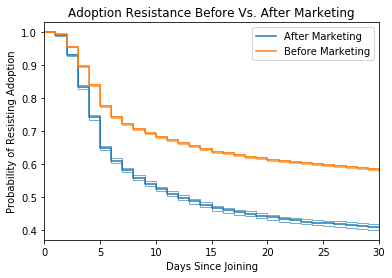

In [503]:
# Plot adoption resistance curves for "After Marketing" (treatment) 
# and "Before Marketing" (control) groups

%matplotlib inline
import lifelines
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

ax = plt.subplot()

new = data[data['user_id'] > 100000]
old = data[data['user_id'] <= 100000] 
kmf.fit(new['duration'], event_observed=new['adopted'], 
        label="After Marketing")
kmf.plot(ax=ax, ci_force_lines=True)
kmf.fit(old['duration'], event_observed=old['adopted'], 
        label="Before Marketing")
kmf.plot(ax=ax, ci_force_lines=True)

plt.xlim(0, 30)
plt.ylabel('Probability of Resisting Adoption')
plt.xlabel('Days Since Joining')
plt.title("Adoption Resistance Before Vs. After Marketing");

#### There seems to be a clear difference between the curves--specifically, adoption resistance is lower for the "After Marketing" group. Ten days after signup, for instance, about 50% of users exposed to the treatment have adopted, while only about (1-0.7) = 30% of users in the control group have adopted. If the marketing is causing the difference, then our marketing is working! We can verify analytically that this difference is statistically significant.

In [504]:
 from lifelines.statistics import logrank_test

 results = logrank_test(new['duration'], old['duration'], 
                        event_observed_A=new['adopted'], 
                        event_observed_B=old['adopted'])
 results.print_summary()

Results
   df: 1
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00000 |           2153.520 |      Reject Null    |        True       


### II. Predicting Future Values With Survival Regression

#### Thus far, we have not considered the effect of the other variables (Phone, Age, State) on adoption. We can do this and predict future adoption using Cox's Proportional Hazard model. 

In [505]:
# Prepare the data for regression by adding a treatment dummy, 
# one hot encoding categorical variables,
# and dropping rows containing missing data

regr_data = data[['duration', 'adopted', 'user_id', 
                  'Phone', 'Age', 'State']]

def add_treatment_dummy(df):
    if df['user_id']>100000:
        return 1
    else:
        return 0

regr_data['treatment'] = regr_data.apply(add_treatment_dummy, 
                                         axis=1)

phone = pd.get_dummies(regr_data['Phone']) # one hot encode 'Phone'

state = pd.get_dummies(regr_data['State']) # one hot encode 'State'

regr_data = pd.concat([regr_data, phone, state], 
                      axis=1)

regr_data.drop(['user_id', 'Phone', 'Android', 'State'], 
               axis=1, 
               inplace=True)

regr_data.dropna(inplace=True) # drop rows with missing values

regr_data.sample(5)

,duration,adopted,Age,treatment,iPhone,AK,AL,AR,AZ,CA,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
23821,253.0,False,17.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
42664,3.0,True,11.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36249,231.0,False,11.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
81981,14.0,True,20.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88697,140.0,False,25.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [506]:
# Fit Cox Proportional Hazard regression model

from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(regr_data, duration_col='duration', event_col='adopted')

cph.print_summary() 

n=30590, number of events=15670

             coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
Age        0.0098     1.0099    0.0007 14.9140 0.0000      0.0086      0.0111  ***
treatment  0.4598     1.5838    0.0235 19.5465 0.0000      0.4137      0.5060  ***
iPhone     0.0090     1.0090    0.0170  0.5292 0.5966     -0.0243      0.0423     
AK         0.3753     1.4555    0.5839  0.6428 0.5203     -0.7693      1.5200     
AL         0.0209     1.0212    0.5130  0.0408 0.9674     -0.9848      1.0267     
AR         0.2194     1.2454    0.5334  0.4114 0.6808     -0.8262      1.2651     
AZ         0.0733     1.0761    0.5050  0.1452 0.8845     -0.9167      1.0634     
CA        -0.1017     0.9033    0.5003 -0.2033 0.8389     -1.0824      0.8791     
CO         0.1186     1.1259    0.5030  0.2357 0.8136     -0.8675      1.1047     
CT        -0.3822     0.6824    0.5061 -0.7551 0.4502     -1.3743      0.6100     
DC        -0.0379     0.9628    0.5042 -0.0753 0.9400 

#### Two things to note: 1) 'Treatment' and 'Age' are the only statistically significant covariates. Holding other factors constant, at any given time a user in the treatment group is ~58% more likely to adopt than a user in the control group (older users also seem to adopt at relatively higher rates, but we might not want to put too much stock in that conclusion until we know more about why we're missing ages for three-quarters of users), and 2) Concordance (a.k.a. c-index) is close to 0.5, meaning the model is not much better than random guessing at predicting outcomes at the individual user level. Fortunately, we need only predict the survival rate of the population as a whole. Let's go ahead and make those predictions for the new cohort.

In [507]:
# Use fitted model to make adoption resistance predictions for users in new cohort

ix = (regr_data['treatment'] == 1) 
treatment = regr_data.loc[ix]

preds = cph.predict_survival_function(treatment)

preds.head()

,100001,100005,100006,100009,100015,100019,100022,100023,100024,100027,...,119942,119944,119947,119961,119965,119971,119979,119982,119986,119987
event_at,,,,,,,,,,,,,,,,,,,,,
0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1.0,0.994595,0.991174,0.992781,0.992851,0.989855,0.991554,0.989746,0.989197,0.990715,0.992267,...,0.986580,0.987958,0.992717,0.992637,0.992238,0.991227,0.989635,0.990547,0.991985,0.992647
2.0,0.955632,0.928456,0.941134,0.941694,0.918163,0.931443,0.917320,0.913065,0.924866,0.937069,...,0.893031,0.903536,0.940628,0.940000,0.936837,0.928875,0.916456,0.923552,0.934837,0.940071
3.0,0.893691,0.832065,0.860489,0.861757,0.809408,0.838712,0.807567,0.798322,0.824120,0.851314,...,0.755642,0.777847,0.859344,0.857922,0.850790,0.832995,0.805685,0.821223,0.846299,0.858084
4.0,0.838598,0.749820,0.790321,0.792145,0.718091,0.759222,0.715535,0.702747,0.738637,0.777164,...,0.644806,0.674726,0.788674,0.786631,0.776415,0.751133,0.712925,0.734574,0.770006,0.786864


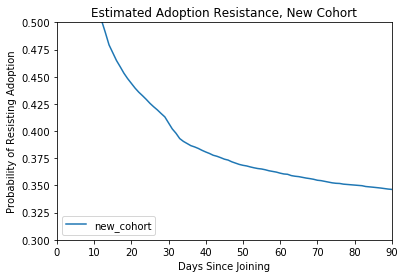

In [508]:
# Return the predicted adoption resistance for entire new cohort and plot curve

new_cohort_pred = pd.DataFrame(data=preds.mean(axis=1), columns=['new_cohort'])

ax = plt.subplot()

new_cohort_pred.plot(ax=ax);

plt.xlim(0, 90)
plt.ylim(0.3, 0.5)
plt.ylabel('Probability of Resisting Adoption')
plt.xlabel('Days Since Joining')
plt.title("Estimated Adoption Resistance, New Cohort");

#### Assuming for simplicity that all 20,000 users joined on April 1 (in reality they joined at various points in the month), on May 1 we would expect about 20,000 x (1 - 40%) = 12,000 users to have adopted. By June 1, we would expect about 20,000 x (1 - 36%) = 12,800 users to have adopted. By July 1, we would expect about 20,000 x (1 - 35%) = 13,000 users to have adopted. Note that the overwhelming majority of adoption comes in the first 30 days of a user's lifetime and plateaus as time goes on. This follows the classic saturation effect of marketing, whereby additional exposures to a product achieve diminishing returns.

## Next Steps

#### In light of these results, there are three immediate next steps we should pursue: 1) Verify our findings with a randomized controlled experiment, 2) Conduct a cost-benefit analysis of our marketing efforts, and 3) Optimize our product marketing mix.

#### 1) Although we have made the best of the data we have, we cannot be certain that marketing efforts are truly causing the increase in adoption. This is because our control and treatment groups were conducted on different populations of users during different time periods. Since the app is constantly evolving, there could have been changes in early 2017 that resulted in increased adoption of PWV. The only way to rule out this possibility is to conduct an A/B test in which a random subset of new users are shielded from PWV product marketing, while at the same time another random subset of new users are exposed to the PWV product marketing.

#### 2) Assuming our conclusions are proven out by the A/B test and the lift in adoption is real, we need to weigh the costs of conducting marketing efforts against the benefits of adoption. On the costs side, it is likely that our marketing efforts come at the expense of other calls to action we could be making of our users, and they almost certainly consume internal resources. On the benefits side, we need to quantify the value of getting a user to adopt PWV. This might involve determining whether using PWV increases customer lifetime value, both directly through PWV revenue and indirectly through increased use of the core product.

#### 3) With a cost-benefit framework in place, we can fine-tune our marketing mix through segmenting by marketing channel. By conducting cost-benefit analysis on each channel individually, we can identify the highest ROI channels and focus future efforts on those channels.